In [4]:
%reload_ext autoreload
%reload_ext line_profiler
%autoreload 2

In [83]:
from multiprocessing import Pool
import experiments
import pickle 
import os 
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
from functools import partial

%matplotlib inline

In [6]:
N = 10
wsqs = (10,50)
tvs = (0.05, 0.5)

if __name__ ==  '__main__': 
    num_processors = 4
    p=Pool(processes = num_processors)
    output = p.starmap(experiments.width_experiment,[(N,wsq,tv) for wsq in wsqs for tv in tvs])
    print(output)

for wsq in wsqs:
    for tv in tvs:
        #pointwise_asym = experiments.evaluate(f'widthpointasym_{wsq}_{tv}.pkl', experiments.pointwise_asym_ci, alpha=0.05, ndata=N, reps=2, wsq=wsq, tv=tv)
        #supermartingale = experiments.evaluate(f'widthsupermartingale_{wsq}_{tv}.pkl', experiments.cs_via_supermartingale_debug, alpha=0.05, ndata=N, reps=2, wsq=wsq, tv=tv)
        supermartingale = experiments.evaluate(f'widthEWA_{wsq}_{tv}.pkl', experiments.cs_via_EWA_debug, alpha=0.05, ndata=N, reps=2, wsq=wsq, tv=tv)


[None, None, None, None]
(10, {'cov': 1.0, 'covstd': 0.0, 'ubcov': 1.0, 'lbcov': 1.0, 'final_width': 1.0, 'widthstd': 0.0, 'widthlo': 1.0, 'widthhi': 1.0, 'ub': 1.0, 'lb': 0.0})
(10, {'cov': 1.0, 'covstd': 0.0, 'ubcov': 1.0, 'lbcov': 1.0, 'final_width': 1.0, 'widthstd': 0.0, 'widthlo': 1.0, 'widthhi': 1.0, 'ub': 1.0, 'lb': 0.0})
(10, {'cov': 1.0, 'covstd': 0.0, 'ubcov': 1.0, 'lbcov': 1.0, 'final_width': 1.0, 'widthstd': 0.0, 'widthlo': 1.0, 'widthhi': 1.0, 'ub': 1.0, 'lb': 0.0})
(10, {'cov': 1.0, 'covstd': 0.0, 'ubcov': 1.0, 'lbcov': 1.0, 'final_width': 1.0, 'widthstd': 0.0, 'widthlo': 1.0, 'widthhi': 1.0, 'ub': 1.0, 'lb': 0.0})


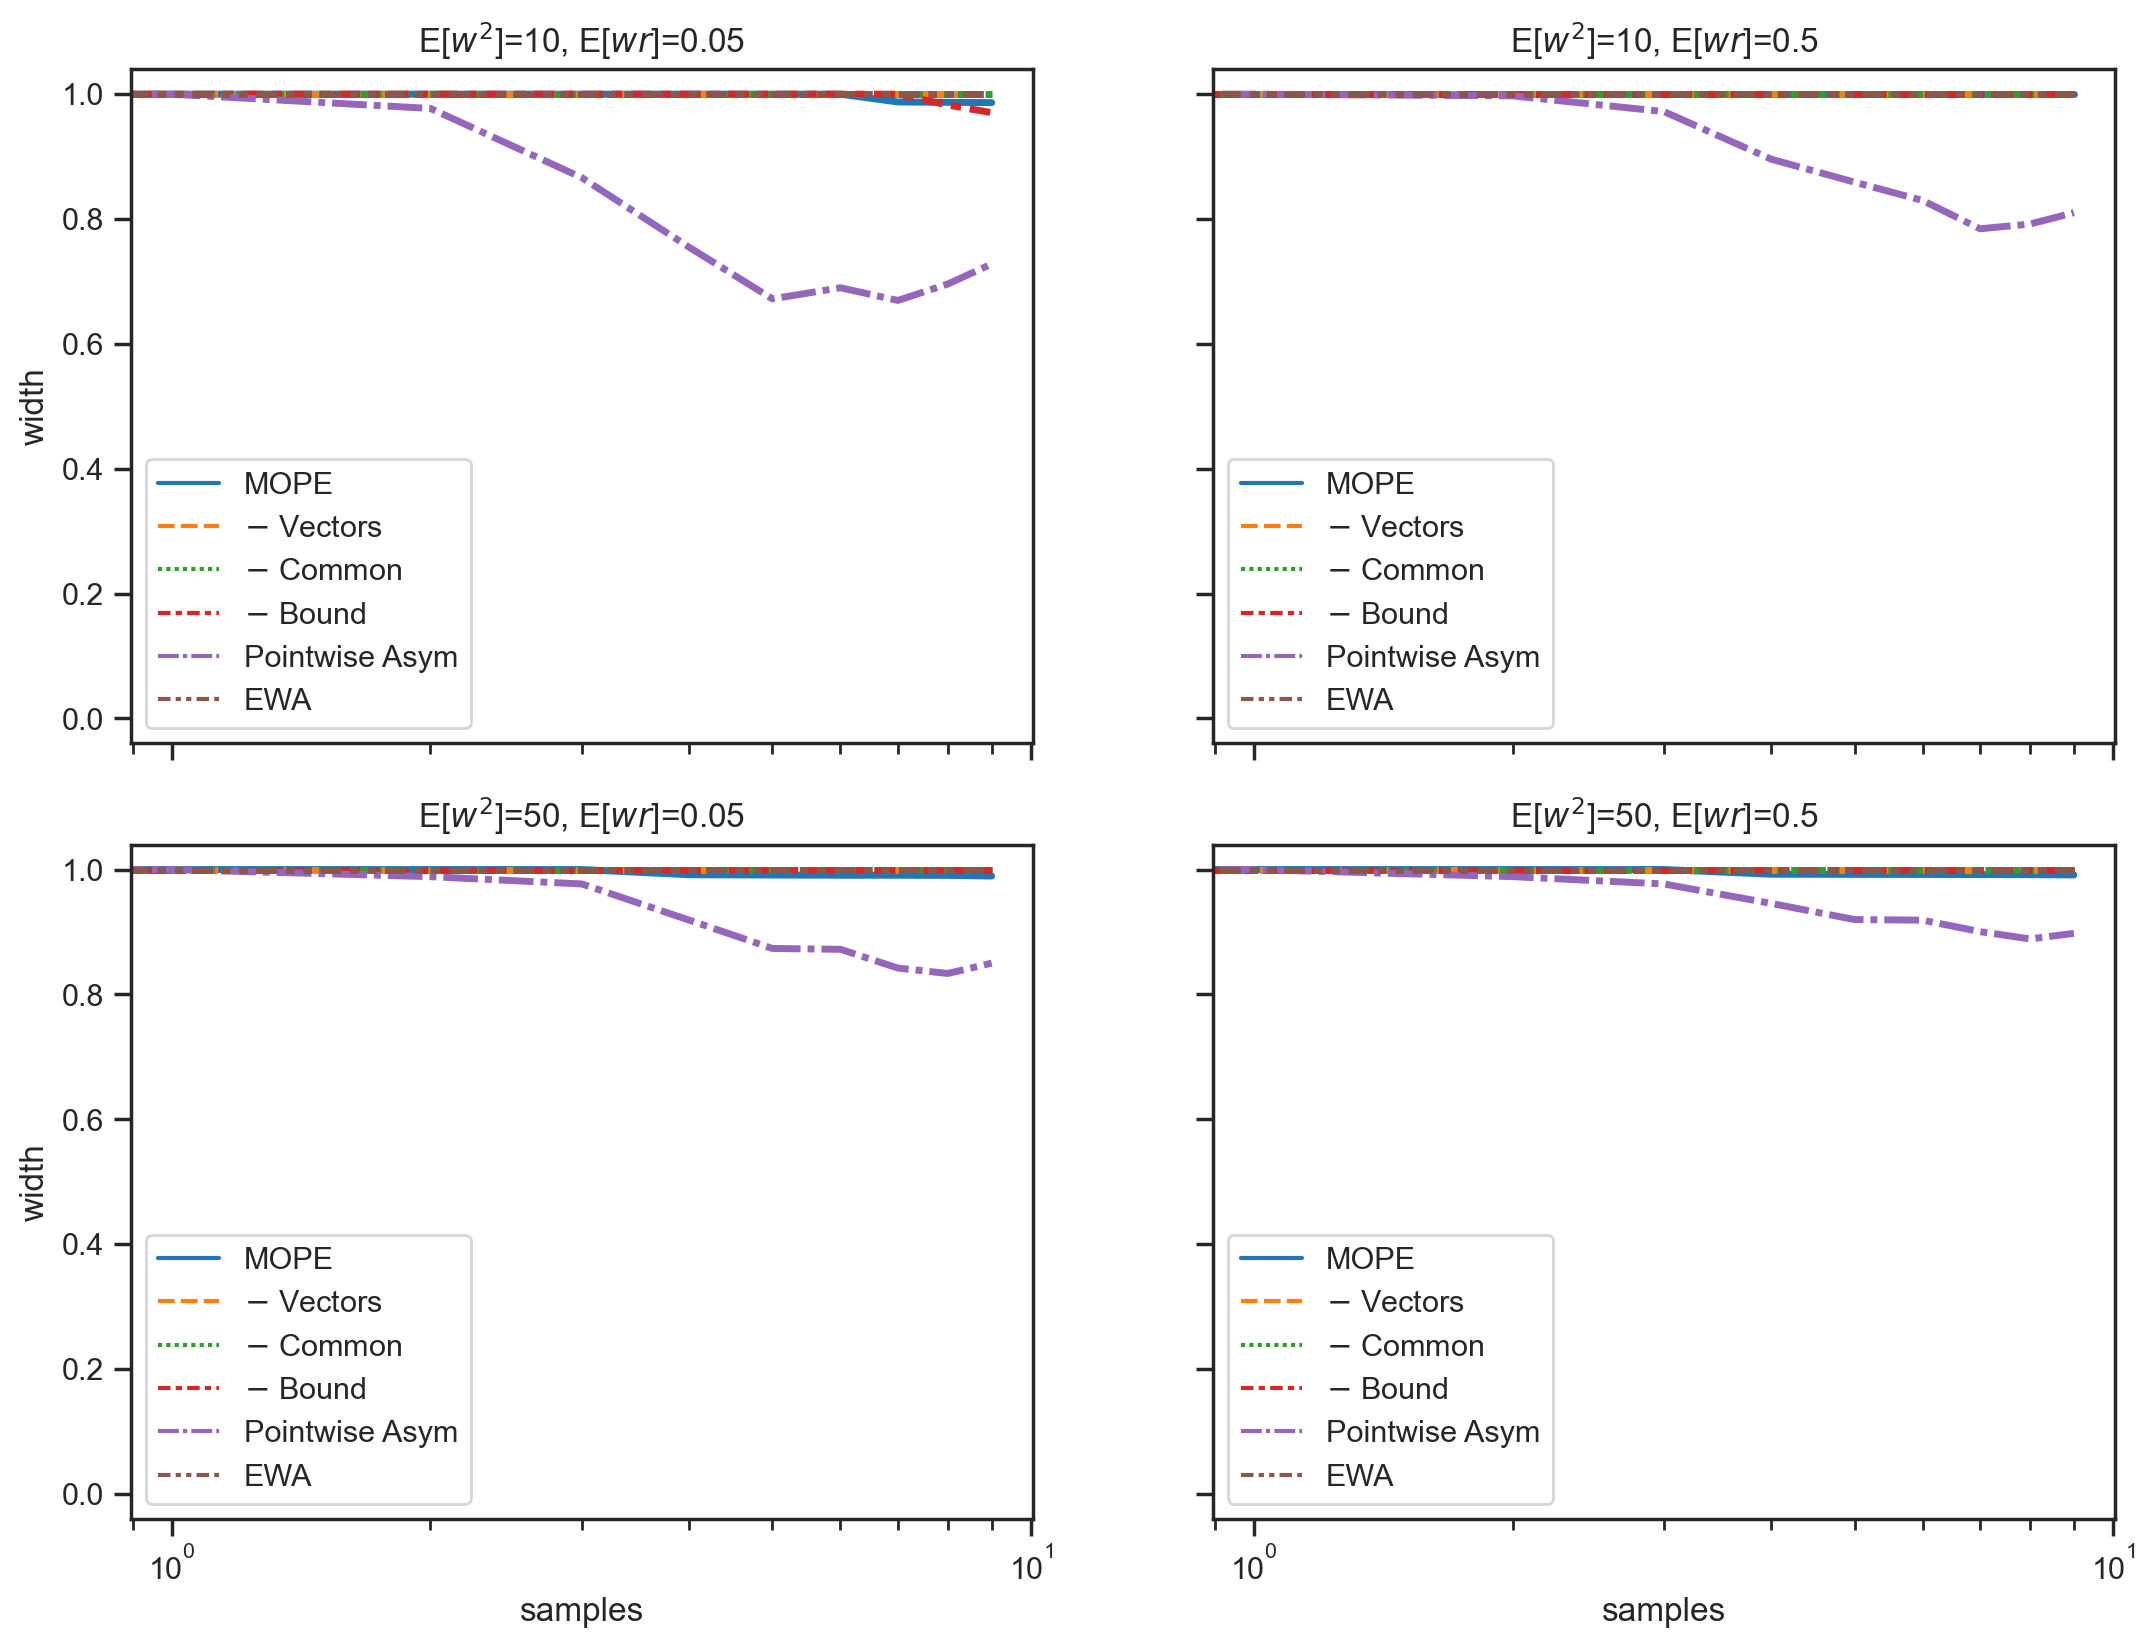

In [58]:
legend = {'2d': 'MOPE', '1d': '$-$ Vectors', 'iqp': '$-$ Common', 'log': '$-$ Bound', 'pointasym': 'Pointwise Asym','EWA': 'EWA'}
fig, ax = plt.subplots(2,2, sharex='col', sharey='row', figsize=(12.8, 9.6), dpi=200, gridspec_kw={'hspace': 0.15})
for i,wsq in enumerate((10, 50)):
    for j,tv in enumerate((0.05, 0.5)):
        d = {}
        for method in '2d','1d','iqp','log', 'pointasym','EWA':
            name = f'width{method}_{wsq}_{tv}.pkl'
            with open(name, 'rb') as pkl:
                d[legend[method]] = pickle.load(pkl)[1]['width']
        experiments.plotit(d,f'E[$w^2$]={wsq}, E[$wr$]={tv}', ax=ax[i,j])
ax[0,0].set(xscale="log")
ax[0,1].set(xscale="log")
ax[0,0].legend(loc='lower left')
ax[0,1].legend(loc='lower left')
#fig.savefig('width.pdf', bbox_inches='tight', pad_inches=0)

## The following takes 4 days to run but eventually produces Figure 2 from the paper

In [84]:
N = 1000
wsqs = (10,50)
tvs = (0.05, 0.5)

if __name__ ==  '__main__': 
    num_processors = 4
    #p=Pool(processes = num_processors)
    #output = p.starmap(experiments.width_experiment,[(N,wsq,tv) for wsq in wsqs for tv in tvs])
    #print(output)

for wsq in wsqs:
    for tv in tvs:
        #pointwise_asym = experiments.evaluate(f'widthpointasym_{wsq}_{tv}.pkl', experiments.pointwise_asym_ci, alpha=0.05, ndata=N, reps=10, wsq=wsq, tv=tv)
        supermartingale = experiments.evaluate(f'widthEWA_{wsq}_{tv}.pkl', experiments.cs_via_EWA_debug, alpha=0.05, ndata=N, reps=10, wsq=wsq, tv=tv)
        supermartingale = experiments.evaluate(f'widthsupermartingale_{wsq}_{tv}.pkl', experiments.cs_via_supermartingale_debug, alpha=0.05, ndata=N, reps=10, wsq=wsq, tv=tv)
        supermartingale = experiments.evaluate(f'widthsupermartingale1d_{wsq}_{tv}.pkl', experiments.cs_via_supermartingale_1d_debug, alpha=0.05, ndata=N, reps=10, wsq=wsq, tv=tv)

(1000, {'cov': 1.0, 'covstd': 0.0, 'ubcov': 1.0, 'lbcov': 1.0, 'final_width': 0.2332, 'widthstd': 0.0136, 'widthlo': 0.1704, 'widthhi': 0.2741, 'ub': 0.2503, 'lb': 0.0171})
(1000, {'cov': 1.0, 'covstd': 0.0, 'ubcov': 1.0, 'lbcov': 1.0, 'final_width': 0.5696, 'widthstd': 0.054, 'widthlo': 0.2722, 'widthhi': 0.7058, 'ub': 0.5746, 'lb': 0.005})


C:\Users\v-zmhammedi\Documents\Reseach\Off-policy-learning\code\mope\cs_via_supermartingale.py:186: RuntimeWarning: divide by zero encountered in double_scalars
  gammasols.append(gamma)
C:\Users\v-zmhammedi\Documents\Reseach\Off-policy-learning\code\mope\cs_via_supermartingale.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  


(1000, {'cov': 1.0, 'covstd': 0.0, 'ubcov': 1.0, 'lbcov': 1.0, 'final_width': 0.9952, 'widthstd': 0.0016, 'widthlo': 0.9884, 'widthhi': 1.0, 'ub': 1.0, 'lb': 0.0048})
(1000, {'cov': 1.0, 'covstd': 0.0, 'ubcov': 1.0, 'lbcov': 1.0, 'final_width': 0.2653, 'widthstd': 0.0206, 'widthlo': 0.1794, 'widthhi': 0.3313, 'ub': 0.6333, 'lb': 0.368})
(1000, {'cov': 1.0, 'covstd': 0.0, 'ubcov': 1.0, 'lbcov': 1.0, 'final_width': 0.5579, 'widthstd': 0.0579, 'widthlo': 0.3373, 'widthhi': 0.7168, 'ub': 0.783, 'lb': 0.2251})
(1000, {'cov': 1.0, 'covstd': 0.0, 'ubcov': 1.0, 'lbcov': 1.0, 'final_width': 0.7818, 'widthstd': 0.0513, 'widthlo': 0.6337, 'widthhi': 1.0, 'ub': 1.0, 'lb': 0.2182})
(1000, {'cov': 1.0, 'covstd': 0.0, 'ubcov': 1.0, 'lbcov': 1.0, 'final_width': 0.4106, 'widthstd': 0.0166, 'widthlo': 0.3524, 'widthhi': 0.491, 'ub': 0.4281, 'lb': 0.0175})
(1000, {'cov': 1.0, 'covstd': 0.0, 'ubcov': 1.0, 'lbcov': 1.0, 'final_width': 0.9947, 'widthstd': 0.0022, 'widthlo': 0.9836, 'widthhi': 1.0, 'ub': 0.9

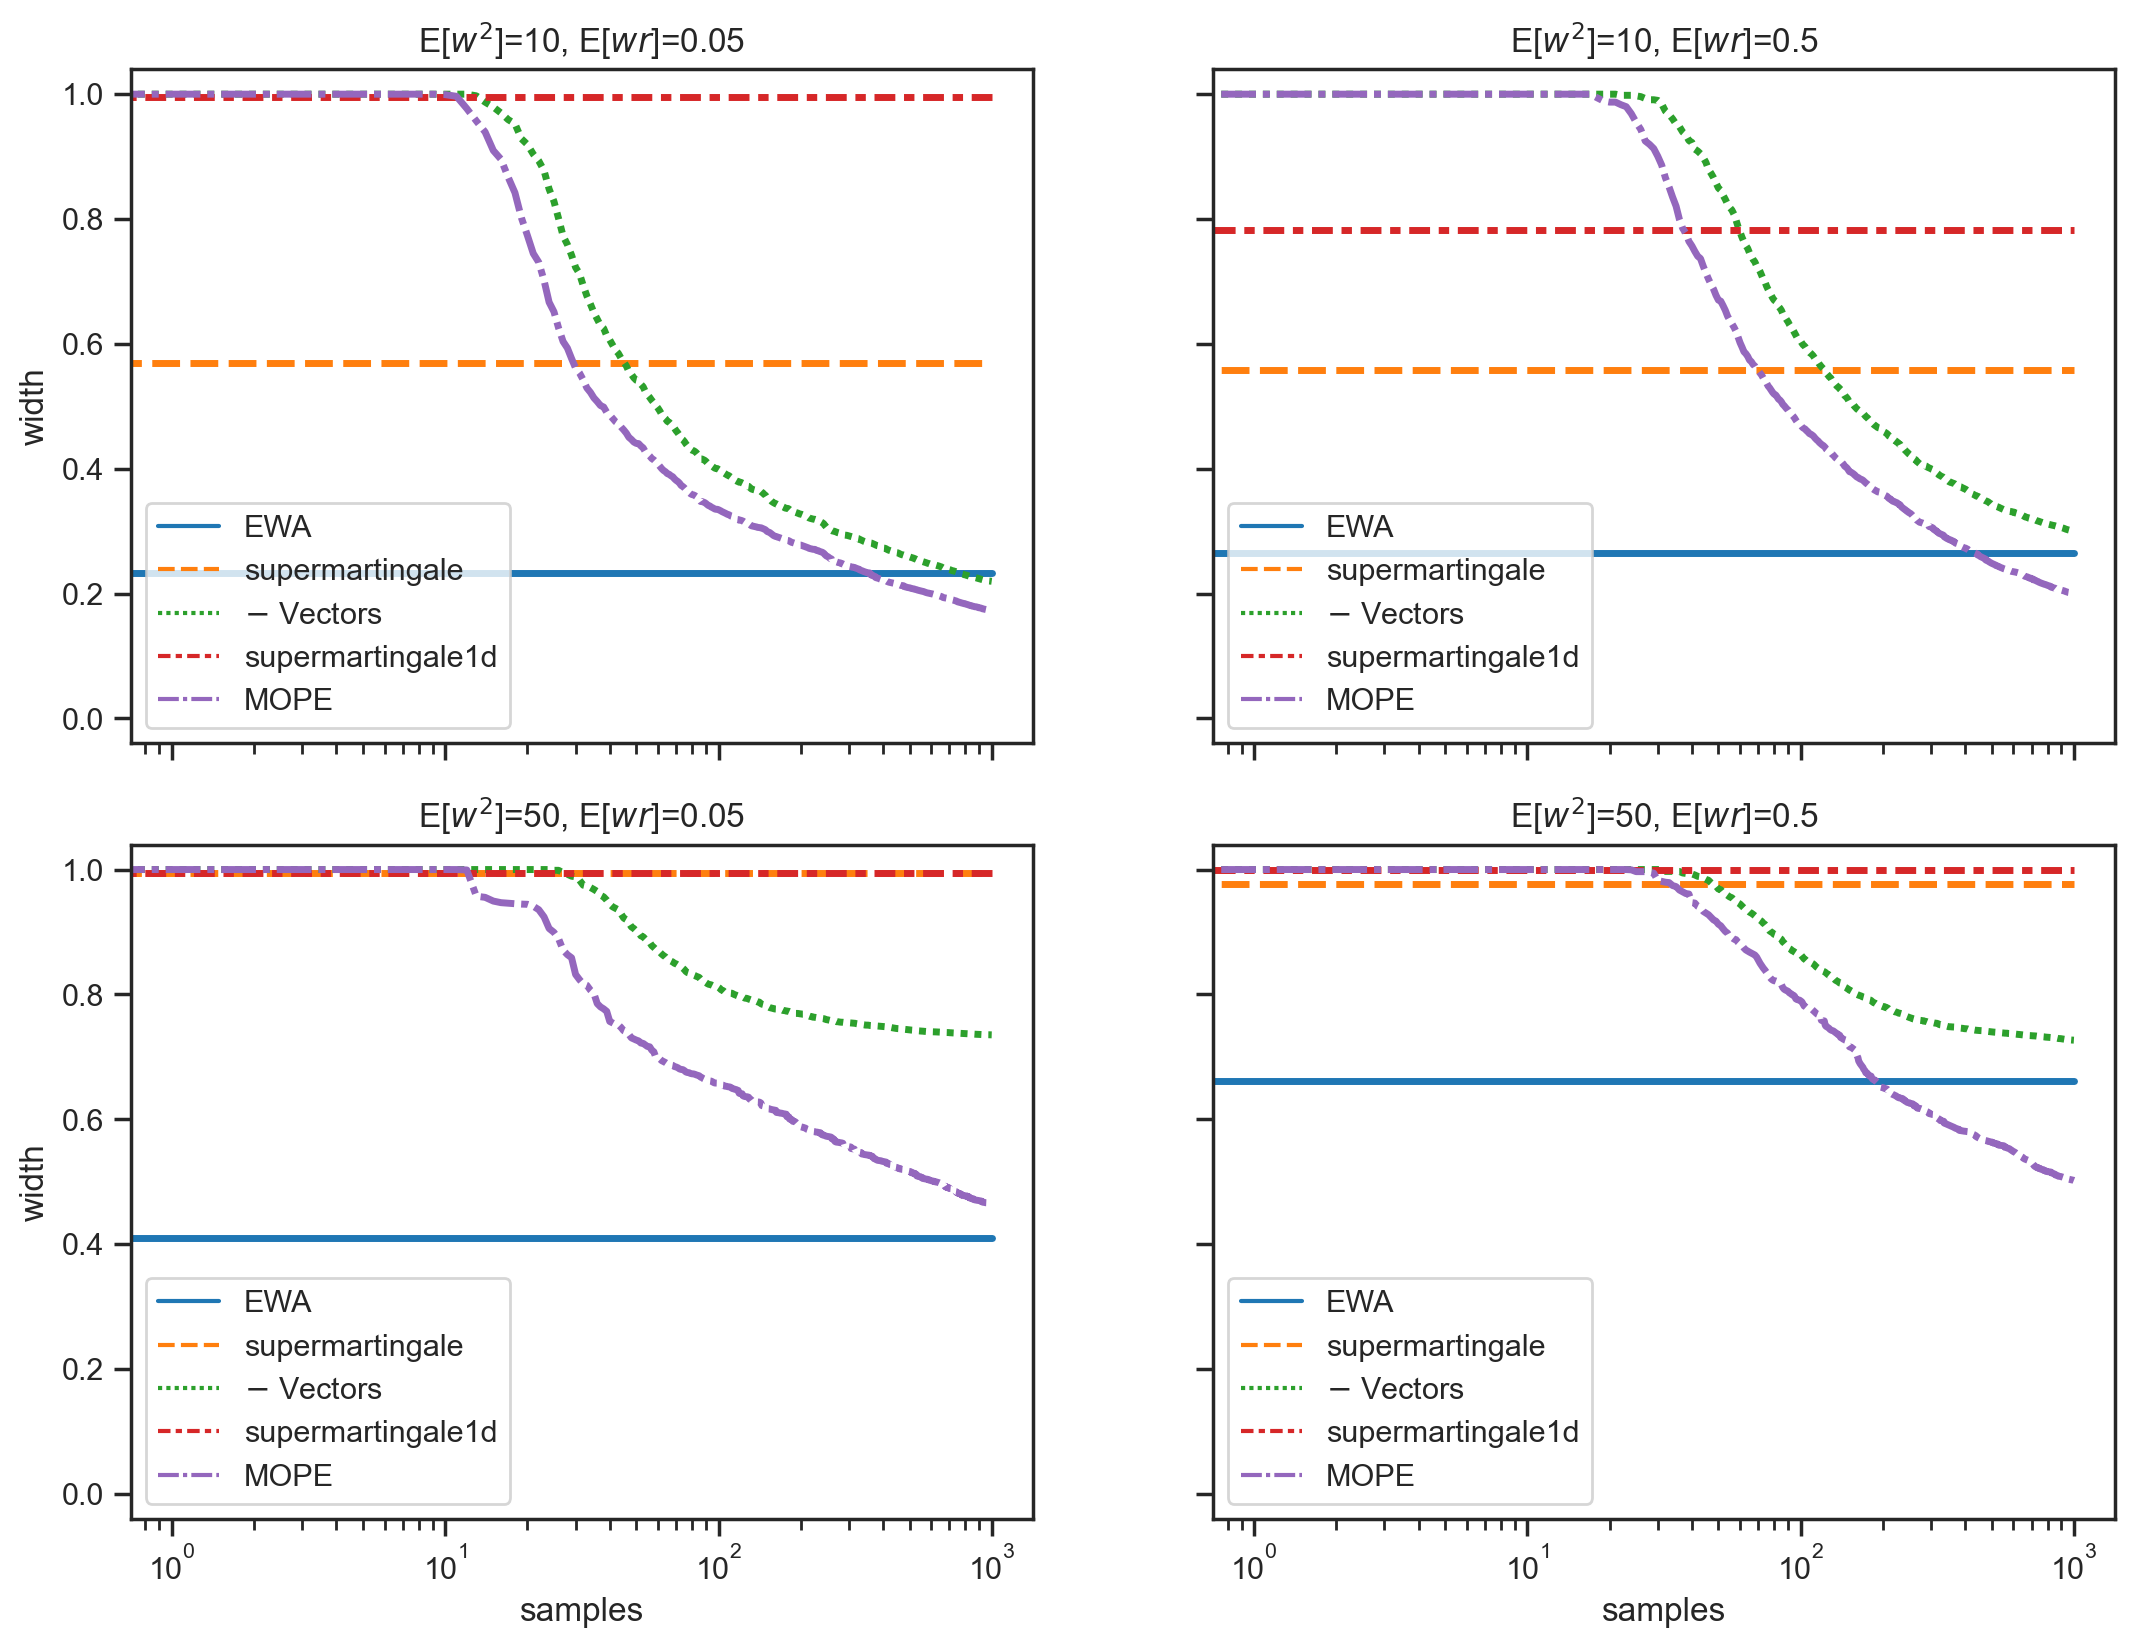

In [85]:
import seaborn as sns
import pandas as pd
def plotit_custom(d, title, ax=None):
    sns.set_theme(style='ticks')
    columns = []
    values = []
    lenmin=0
    for k in d:
        columns.append(k)
        if lenmin==0 or len(d[k])<lenmin:
            lenmin=len(d[k])
    for k in d:
        values.append(d[k][:lenmin])
        
    values = np.stack(values, axis=1)
    data = pd.DataFrame(values, columns=columns)
    if ax is None:
        fig, ax = plt.subplots()
    sns.lineplot(data=data, palette="tab10", linewidth=2.5, ci=None, ax=ax)
    ax.set(xlabel="samples", ylabel="width", ylim=(-0.04,1.04), title=title)
    ax.legend(loc='lower left')
    return ax


#legend = {'2d': 'MOPE', '1d': '$-$ Vectors', 'iqp': '$-$ Common', 'log': '$-$ Bound', 'pointasym': 'Pointwise Asym', 'supermartingale':'supermartingale','EWA':'EWA'}
#legend = {'EWA':'EWA','supermartingale':'supermartingale'} 
legend = {'2d':'MOPE','1d': '$-$ Vectors','EWA':'EWA','supermartingale':'supermartingale','supermartingale1d':'supermartingale1d'} 

fig, ax = plt.subplots(2,2, sharex='col', sharey='row', figsize=(12.8, 9.6), dpi=200, gridspec_kw={'hspace': 0.15})
for i,wsq in enumerate((10, 50)):
    for j,tv in enumerate((0.05, 0.5)):
        d = {}
        #for method in {'EWA','supermartingale'}: 
        for method in {'2d','1d','EWA','supermartingale','supermartingale1d'}: 
            name = f'width{method}_{wsq}_{tv}.pkl'
            with open(name, 'rb') as pkl:
                d[legend[method]] = pickle.load(pkl)[1]['width']
        #experiments.plotit(d,f'E[$w^2$]={wsq}, E[$wr$]={tv}', ax=ax[i,j])
        plotit_custom(d,f'E[$w^2$]={wsq}, E[$wr$]={tv}', ax=ax[i,j])
ax[0,0].set(xscale="log")
ax[0,1].set(xscale="log")
ax[0,0].legend(loc='lower left')
ax[0,1].legend(loc='lower left')
fig.savefig('width.pdf', bbox_inches='tight', pad_inches=0)

In [36]:
from cs_via_supermartingale import bisection_algorithm, supermartingale_value, linear_search, martingale_value_lowerbound
#martval0 = lambda v: supermartingale_value(v,100,b0,b1,A0,A1,A2)
martval0 = lambda v: martingale_value_lowerbound(v,100,b0,b1,A0,A1,A2,1)
tmpv = linear_search(martval0,0,1,1/(2 * 0.05),step=0.0001)

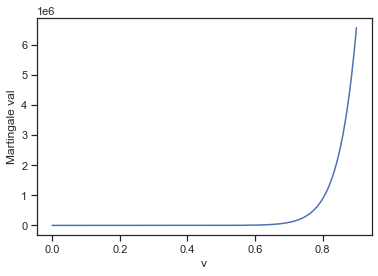

In [37]:
# Trying to plot as a function of v
Nv = 1000
grid_v =np.linspace(0,.9,Nv)
mvalues = np.zeros(Nv)
for i, v in enumerate(grid_v):
    mvalues[i]=martval0(v)
    
plt.plot(grid_v,mvalues)

plt.xlabel("v")
plt.ylabel("Martingale val")
plt.show()